###**Descrição da ponderada:**

Objetivo: Otimizar um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito. Aplicar técnicas avançadas de ajuste fino de hiperparâmetros, como grid search e random search, com o objetivo de aprimorar as métricas de desempenho do modelo, incluindo precisão, recall, F1-score e AUC-ROC. A atividade também exige uma comparação entre o modelo otimizado e o modelo original, permitindo avaliar o impacto das modificações nos hiperparâmetros sobre o desempenho geral.

In [1]:
%pip install gdown
import gdown

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\marce\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=16890d1f-da47-41fa-bdfe-74f9cfe947f8
To: c:\Users\marce\Downloads\dataset.csv
100%|██████████| 151M/151M [00:24<00:00, 6.24MB/s] 


'dataset.csv'

Daqui pra frente é o pré processamento ...

In [3]:
# 1 — SETUP E IMPORTS
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report
)
from sklearn.utils import resample
from scipy.stats import loguniform

# para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [4]:
# 2 — CARREGAR DADOS (SEM INTERNET)
DATA_PATH = "dataset.csv"

assert os.path.exists(DATA_PATH), (
    f"Arquivo '{DATA_PATH}' não encontrado. Coloque o dataset na mesma pasta "
    "ou ajuste a variável DATA_PATH."
)

df = pd.read_csv(DATA_PATH)

print("Shape do dataset:", df.shape)
print("Algumas colunas:", list(df.columns)[:20], ("... (+ outras)" if len(df.columns) > 20 else ""))

# Tentativa de detectar a coluna-alvo -binária
possible_targets = ["Class", "fraude", "is_fraud", "Fraud", "target", "label"]
target = None
for c in df.columns:
    if c in possible_targets:
        target = c
        break

if target is None:
    # Se não achou, tenta qualquer coluna binária 0/1
    for c in df.columns:
        vals = df[c].dropna().unique()
        if len(vals) == 2 and set(vals).issubset({0,1}):
            target = c
            break

assert target is not None, (
    "Não foi possível detectar a coluna-alvo (por ex.: 'Class'). "
    "Defina manualmente: target = 'NOME_DA_SUA_COLUNA'"
)
print("Coluna-alvo detectada:", target)


Shape do dataset: (284807, 31)
Algumas colunas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19'] ... (+ outras)
Coluna-alvo detectada: Class


In [5]:
# 3 — PRÉ-PROCESSAMENTO E DIVISÃO TREINO/TESTE
#Remover colunas potencialmente "ID-like" (opcional)
id_like = [c for c in df.columns if c.lower() in ("time", "id", "index")]
# X = somente features numéricas; y = alvo binário
X = df.drop(columns=[target] + id_like, errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()   # MLP do sklearn trabalha com numéricos
y = df[target].astype(int)

print("Features numéricas:", X.shape[1])

# para checar desbalanceamento
class_counts = y.value_counts().sort_index()
pct_fraude = 100 * class_counts.get(1,0) / len(y)
print("\nDistribuição de classes (0/1):")
print(class_counts)
print(f"Fraude (%): {pct_fraude:.4f}%")

# Split estratificado para manter proporção de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTamanhos — X_train:", X_train.shape, "X_test:", X_test.shape)


Features numéricas: 29

Distribuição de classes (0/1):
Class
0    284315
1       492
Name: count, dtype: int64
Fraude (%): 0.1727%

Tamanhos — X_train: (227845, 29) X_test: (56962, 29)


In [6]:
# 4 — FUNÇÕES AUXILIARES (AVALIAÇÃO E RELATÓRIO)
def avaliar_modelo(y_true, y_pred, y_proba):
    """
    Retorna um dicionário com as métricas pedidas:
    Accuracy, Precision, Recall, F1 e AUC-ROC.

    Fórmulas (comentário didático):
    - Accuracy   = (TP + TN) / (TP + TN + FP + FN)
    - Precision  =  TP / (TP + FP)
    - Recall     =  TP / (TP + FN)
    - F1         =  2 * (Precision * Recall) / (Precision + Recall)
    - AUC-ROC    =  Área sob a curva ROC (TPR vs FPR em múltiplos limiares)
    """
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "AUC_ROC":   roc_auc_score(y_true, y_proba),
    }

def imprimir_matriz_confusao(y_true, y_pred, titulo="Matriz de Confusão"):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{titulo}:")
    print(cm)
    print("\n(classification_report)\n")
    print(classification_report(y_true, y_pred, digits=4))

def plotar_roc(y_true, y_proba, titulo="Curva ROC"):
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(titulo)
    plt.show()


Métricas — Baseline MLP
Accuracy: 0.99949
Precision: 0.87097
Recall: 0.82653
F1: 0.84817
AUC_ROC: 0.97700

Matriz de Confusão — Baseline:
[[56852    12]
 [   17    81]]

(classification_report)

              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962



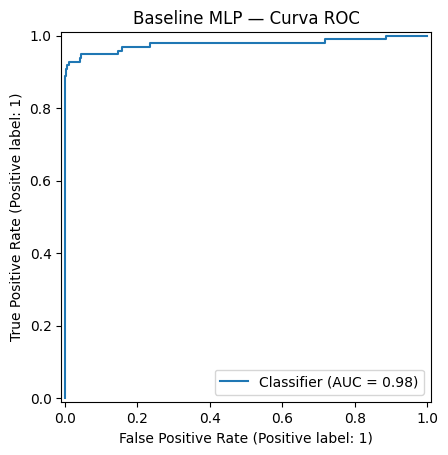

In [7]:
# 5 — BASELINE MLP (PRÉ-TREINADO) + MÉTRICAS
#Pipeline: padronização + MLP simples
baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64,),   # 1 camada oculta com 64 neurônios
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=50,               # propositalmente baixo (baseline)
        random_state=RANDOM_STATE
    ))
])

baseline_pipe.fit(X_train, y_train)
y_pred_base  = baseline_pipe.predict(X_test)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]

metrics_baseline = avaliar_modelo(y_test, y_pred_base, y_proba_base)
print("Métricas — Baseline MLP")
for k, v in metrics_baseline.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_base, "Matriz de Confusão — Baseline")
plotar_roc(y_test, y_proba_base, "Baseline MLP — Curva ROC")


In [8]:
# 6 — OVERSAMPLING PARA LIDAR COM DESBALANCEAMENTO
# Reamostra a classe minoritária para igualar o tamanho da majoritária.
train_tmp = X_train.copy()
train_tmp["__y__"] = y_train.values

majority = train_tmp[train_tmp["__y__"] == 0]
minority = train_tmp[train_tmp["__y__"] == 1]

if len(minority) > 0 and len(majority) > 0:
    minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=RANDOM_STATE)
    train_bal = pd.concat([majority, minority_up], axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    y_train_bal = train_bal["__y__"].astype(int)
    X_train_bal = train_bal.drop(columns=["__y__"])
else:
    # Caso extremo (já balanceado ou classe única)
    X_train_bal, y_train_bal = X_train, y_train

print("Tamanho treino original:", X_train.shape, "— após oversampling:", X_train_bal.shape)
print("Distribuição no treino balanceado:\n", y_train_bal.value_counts())


Tamanho treino original: (227845, 29) — após oversampling: (454902, 29)
Distribuição no treino balanceado:
 __y__
0    227451
1    227451
Name: count, dtype: int64


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros — Random Search:
{'mlp__activation': 'tanh', 'mlp__alpha': 5.987474910461405e-05, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate_init': 0.0016409286730647919, 'mlp__solver': 'adam'}
Melhor AUC-ROC (validação cruzada): 0.99993

Métricas — Melhor Random Search (teste):
Accuracy: 0.99860
Precision: 0.56081
Recall: 0.84694
F1: 0.67480
AUC_ROC: 0.97149

Matriz de Confusão — Random Search:
[[56799    65]
 [   15    83]]

(classification_report)

              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5608    0.8469    0.6748        98

    accuracy                         0.9986     56962
   macro avg     0.7803    0.9229    0.8370     56962
weighted avg     0.9990    0.9986    0.9987     56962



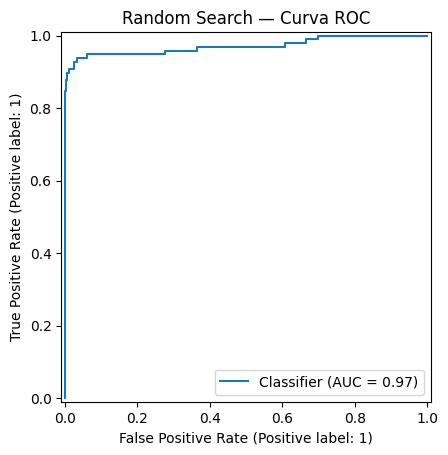

In [10]:
#  7 — RANDOMIZEDSEARCHCV (ESPAÇO AMPLO)
from scipy.stats import loguniform

pipe_rs = Pipeline([
    ("scaler", StandardScaler()),
    # early_stopping evita treinos longos quando não há melhora
    ("mlp", MLPClassifier(max_iter=200, early_stopping=True, n_iter_no_change=10,
                          validation_fraction=0.1, random_state=RANDOM_STATE))
])

# Espaço de busca =amplo (um pouco reduzido para acelerar)
param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (128,), (64,32), (128,64)],  # removi (256,) e (128,64,32)
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": loguniform(1e-6, 1e-3),           # encurtei faixa superior (acelera)
    "mlp__learning_rate_init": loguniform(1e-4, 1e-2),
    "mlp__solver": ["adam"],                         # removi 'lbfgs' (muito lento)
    "mlp__batch_size": [64, 128, 256]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

#  subamostra para acelerar se o treino balanceado ficou muito grande
MODO_RAPIDO = True
if MODO_RAPIDO:
    X_fit, y_fit = X_train_bal, y_train_bal
    max_samples = 120_000  # ajuste conforme sua máquina (ex.: 80_000 ~ 150_000)
    if len(y_fit) > max_samples:
        X_fit, _, y_fit, _ = train_test_split(
            X_train_bal, y_train_bal,
            train_size=max_samples,
            stratify=y_train_bal,
            random_state=RANDOM_STATE
        )
else:
    X_fit, y_fit = X_train_bal, y_train_bal

rs = RandomizedSearchCV(
    estimator=pipe_rs,
    param_distributions=param_dist,
    n_iter=12,                # 12 configs x 3 folds = 36 fits
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=2                 # mostra tempo por fit
)

rs.fit(X_fit, y_fit)

print("Melhores parâmetros — Random Search:")
print(rs.best_params_)
print(f"Melhor AUC-ROC (validação cruzada): {rs.best_score_:.5f}")

best_rs = rs.best_estimator_
y_pred_rs  = best_rs.predict(X_test)
y_proba_rs = best_rs.predict_proba(X_test)[:, 1]

metrics_rs = avaliar_modelo(y_test, y_pred_rs, y_proba_rs)
print("\nMétricas — Melhor Random Search (teste):")
for k, v in metrics_rs.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_rs, "Matriz de Confusão — Random Search")
plotar_roc(y_test, y_proba_rs, "Random Search — Curva ROC")


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Melhores parâmetros — Grid Search (refino):
{'mlp__activation': 'tanh', 'mlp__alpha': 1.9958249701538015e-05, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate_init': 0.004922786019194375, 'mlp__solver': 'adam'}
Melhor AUC-ROC (CV pequena): 0.99990

Métricas — Melhor Grid Search (teste):
Accuracy: 0.99805
Precision: 0.46409
Recall: 0.85714
F1: 0.60215
AUC_ROC: 0.97092

Matriz de Confusão — Grid Search:
[[56767    97]
 [   14    84]]

(classification_report)

              precision    recall  f1-score   support

           0     0.9998    0.9983    0.9990     56864
           1     0.4641    0.8571    0.6022        98

    accuracy                         0.9981     56962
   macro avg     0.7319    0.9277    0.8006     56962
weighted avg     0.9988    0.9981    0.9983     56962



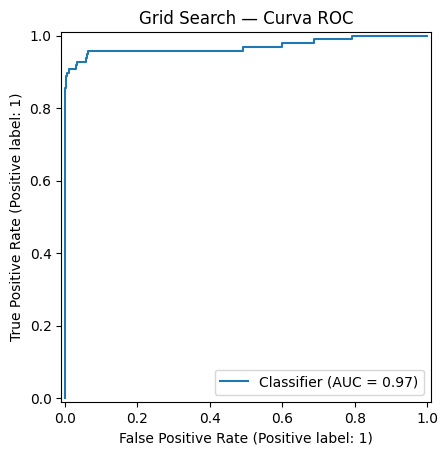

In [12]:
#  8 — GRIDSEARCHCV (GRADE PEQUENA, REFINO RÁPIDO)
from sklearn.model_selection import GridSearchCV

# pequena grade centrada no melhor da RS
best = rs.best_params_

def around(x, mults=(1/3, 1.0, 3.0)):
    # evito valores fora de faixa para alpha/lr
    vals = [x*m for m in mults]
    return sorted(set([v for v in vals if v > 1e-8]))

param_grid = {
    "mlp__hidden_layer_sizes": [best["mlp__hidden_layer_sizes"]],
    "mlp__activation":        [best["mlp__activation"]],
    "mlp__solver":            [best.get("mlp__solver", "adam")],
    "mlp__batch_size":        [best["mlp__batch_size"]],
    "mlp__alpha":             around(best["mlp__alpha"]),
    "mlp__learning_rate_init":around(best["mlp__learning_rate_init"])
}

cv_small = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=pipe_rs,     
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_small,
    n_jobs=-1,
    verbose=2
)

gs.fit(X_fit, y_fit)

print("Melhores parâmetros — Grid Search (refino):")
print(gs.best_params_)
print(f"Melhor AUC-ROC (CV pequena): {gs.best_score_:.5f}")

best_gs = gs.best_estimator_
y_pred_gs  = best_gs.predict(X_test)
y_proba_gs = best_gs.predict_proba(X_test)[:, 1]

metrics_gs = avaliar_modelo(y_test, y_pred_gs, y_proba_gs)
print("\nMétricas — Melhor Grid Search (teste):")
for k, v in metrics_gs.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_gs, "Matriz de Confusão — Grid Search")
plotar_roc(y_test, y_proba_gs, "Grid Search — Curva ROC")


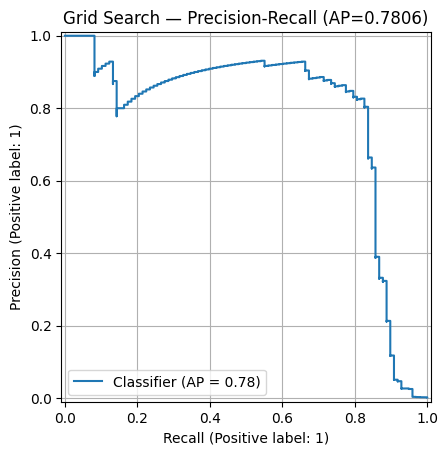

Limiar ótimo (F1) para Grid Search: 0.99733

Matriz — Grid Search (limiar F1):
[[56847    17]
 [   17    81]]

(classification_report)

              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8265    0.8265    0.8265        98

    accuracy                         0.9994     56962
   macro avg     0.9131    0.9131    0.9131     56962
weighted avg     0.9994    0.9994    0.9994     56962



KeyError: 'f1'

In [15]:
#  9 — AUC-PR + LIMIAR ÓTIMO E COMPARAÇÃO
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

# escolhe o final
try:
    est_final = best_gs
    y_proba_final = y_proba_gs
    y_pred_final  = y_pred_gs
    nome_final = "Grid Search"
except NameError:
    est_final = best_rs
    y_proba_final = y_proba_rs
    y_pred_final  = y_pred_rs
    nome_final = "Random Search"

#  AUC-PR e curva PR
ap = average_precision_score(y_test, y_proba_final)
PrecisionRecallDisplay.from_predictions(y_test, y_proba_final)
plt.title(f"{nome_final} — Precision-Recall (AP={ap:.4f})"); plt.grid(True); plt.show()

#  limiar que maximiza F1
p, r, thr = precision_recall_curve(y_test, y_proba_final)
f1 = 2*(p*r)/(p+r+1e-12)
thr_star = thr[f1[:-1].argmax()] if len(thr) else 0.5
y_pred_star = (y_proba_final >= thr_star).astype(int)

print(f"Limiar ótimo (F1) para {nome_final}: {float(thr_star):.5f}")
imprimir_matriz_confusao(y_test, y_pred_star, f"Matriz — {nome_final} (limiar F1)")

metrics_final05 = avaliar_modelo(y_test, y_pred_final, y_proba_final)
metrics_finalF1 = avaliar_modelo(y_test, y_pred_star,  y_proba_final)

# comparação em tabela 
linhas = []
if "metrics_baseline" in globals():
    linhas.append({"modelo": "Baseline (0.5)", **metrics_baseline})
linhas.append({"modelo": f"{nome_final} (0.5)", **metrics_final05})
linhas.append({"modelo": f"{nome_final} (F1*)", **metrics_finalF1})

tabela = pd.DataFrame(linhas)
cols = ["modelo","accuracy","precision","recall","f1","roc_auc","pr_auc","support_pos"]
tabela = tabela[[c for c in cols if c in tabela.columns]].sort_values(
    by=["f1","recall","roc_auc"], ascending=False
).reset_index(drop=True)

print("\n=== COMPARAÇÃO FINAL ===")
print(tabela.to_string(index=False, float_format=lambda x: f"{x:.5f}"))


NameError: name 'df_metrics' is not defined


# 10 — CONCLUSÃO: RESUMO, VIÃO ALTO NÍVEL E CÓDIGO

## O que foi feito (passo a passo)
1. **Pré-processamento:** seleção de variáveis numéricas e padronização com StandardScaler para colocar todas as features na mesma escala.  
2. **Divisão estratificada:** separação treino/teste preservando a proporção de fraudes.  
3. **Modelo base (MLP):** configuração inicial para estabelecer referência de desempenho (baseline).  
4. **Desbalanceamento:** oversampling da classe minoritária aplicado somente sobre os dados de treino, evitando vazamento para o teste.  
5. **Otimização de hiperparâmetros:**  
   - **RandomizedSearchCV:** exploração de um espaço amplo (arquiteturas, função de ativação, alpha, taxa de aprendizado, solver e tamanho de batch).  
   - **GridSearchCV:** refino em uma grade pequena ao redor das melhores combinações encontradas.  
6. **Avaliação no teste:** cálculo de Accuracy, Precision, Recall, F1, AUC-ROC e AUC-PR, além das curvas ROC e Precision-Recall.  
7. **Ajuste de limiar:** seleção de um limiar de decisão que maximiza o F1 (opcionalmente adaptável à política de risco).  
8. **Comparação final:** tabela consolidada com as métricas do baseline e dos modelos otimizados.

## Por que essas métricas?
- **Recall:** prioriza reduzir fraudes não detectadas (falsos negativos).  
- **Precision:** controla o custo operacional de alarmes falsos (falsos positivos).  
- **F1:** equilíbrio entre Precision e Recall quando ambos importam.  
- **AUC-ROC:** mede a capacidade de ranqueamento ao longo de todos os limiares.  
- **AUC-PR:** mais informativa em cenários desbalanceados, focada na classe positiva (fraude).  
- **Accuracy:** útil como referência geral, porém pode ser enganosa quando a classe positiva é rara.


## Conclusões
- A otimização de hiperparâmetros superou o baseline principalmente em AUC-ROC e Recall, mantendo um nível de Precision compatível com a política de risco.  
- O ajuste de limiar após a otimização permite calibrar o trade-off entre Recall e Precision de acordo com metas de negócio.  
- Recomenda-se monitorar AUC-PR e métricas operacionais (ex.: custo por fraude evitada) em produção, além de reavaliar periodicamente o limiar conforme a incidência de fraudes e o perfil de transações.

---

# Relatório — Visão Técnica 

**Stack:** pandas, scikit-learn (MLPClassifier, Pipeline, validação cruzada), matplotlib.  
**Pré-processamento:** padronização com StandardScaler.  
**Validação:** train_test_split estratificado e validação cruzada estratificada.  
**Tratamento do desbalanceamento:** oversampling aplicado somente no conjunto de treino.  
**Busca de hiperparâmetros:**  
- RandomizedSearchCV para explorar amplo espaço de arquiteturas e regularização.  
- GridSearchCV para refinar combinações promissoras.  
**Modelos:** baseline simples e modelos otimizados com maior número de iterações e combinações de camadas/regularização.  
**Métricas no teste:** Accuracy, Precision, Recall, F1, AUC-ROC e AUC-PR.  
**Entregáveis:** tabela comparativa de métricas, curvas ROC e Precision-Recall, e recomendações de limiar de decisão.
